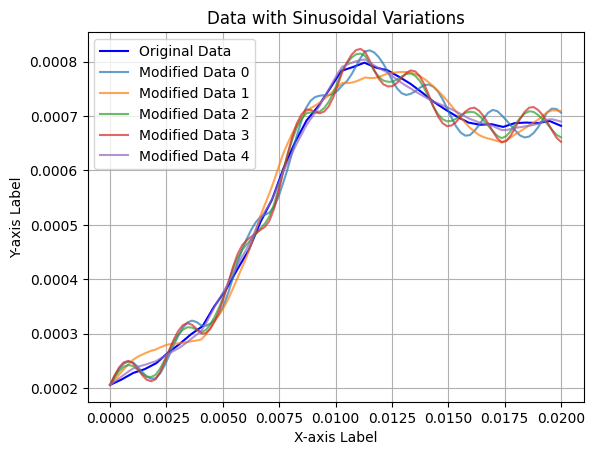

Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_0.txt
Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_1.txt
Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_2.txt
Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_3.txt
Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_4.txt
Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_5.txt
Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_6.txt
Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_7.txt
Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_8.txt
Saved modified data to pitch_profiles/modified_data_with_sinusoidal_variations\coil_h_profile_9.txt


In [33]:
# pitch generation around a specific pitch profile

import numpy as np
import matplotlib.pyplot as plt
import os

data_path = "pitch_profiles\DB2_profile\laser_shot_56_e28.txt"

# Load the data from the text file
data = np.loadtxt(data_path)

# Create sinusoidal variations within the envelope
data_copies = []
for i in range(100):
    # Create a copy of the data
    data_copy = np.zeros((2, 100))

    # upscale the data from 40 points to 100 points
    x = np.linspace(data[0, 0], data[0, -1], 100)
    y = np.interp(x, data[0], data[1])
    data_copy[0] = x
    data_copy[1] = y

    sin_amplitude = np.random.uniform(0.000005, 0.00003)  # Random amplitude for sinusoidal variation
    sin_frequency = np.random.uniform(30, 500)  # Random frequency for sinusoidal variation

    # Add sinusoidal variations
    sinusoidal_variation = sin_amplitude * np.sin(2 * np.pi * sin_frequency * data_copy[0])
    data_copy[1] = data_copy[1] + sinusoidal_variation

    # Append the modified copy to the list
    data_copies.append(data_copy)

# Plot the original and modified profiles
plt.figure()
plt.plot(data[0], data[1], label='Original Data', color='blue')
for i in range(5):  # Plot a few modified profiles
    plt.plot(data_copies[i][0], data_copies[i][1], label=f'Modified Data {i}', alpha=0.7)
plt.xlabel('X-axis Label')
plt.ylabel('Y-axis Label')
plt.title('Data with Sinusoidal Variations')
plt.legend()
plt.grid()
plt.show()

# Save the modified profiles
folder_path = "pitch_profiles/modified_data_with_sinusoidal_variations"
if not os.path.exists(folder_path):
    os.makedirs(folder_path)

for i, data_copy in enumerate(data_copies):
    file_path = os.path.join(folder_path, f"coil_h_profile_{i}.txt")
    np.savetxt(file_path, data_copy)
    print(f"Saved modified data to {file_path}")

Failed to generate 0 profiles out of 30


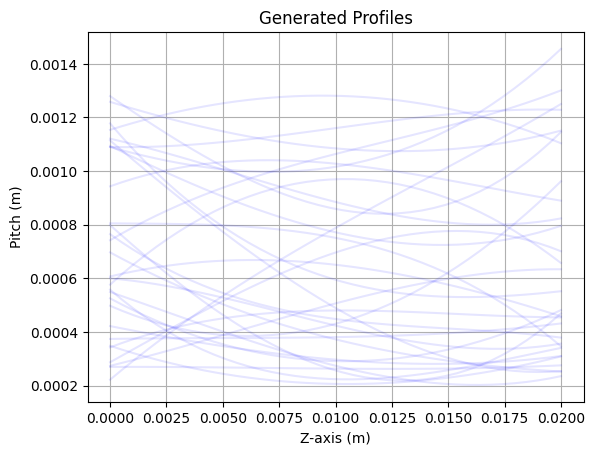

'all_functions_simple = [\n    linear_profile_func,\n    exponential_profile_func,\n    exponential_profile_func_one_bump,\n    exponential_profile_func_two_bumps,\n    degree2_profile_func,\n    degree3_profile_func,\n    gaussian_profile_func,\n    asymetric_gaussian_profile_func,\n    mixture_of_gaussians_profile_func_2,\n    mixture_of_gaussians_profile_func_3,\n    mixture_of_gaussians_profile_func_4,\n    mixture_of_gaussians_profile_func_5,\n    mixture_of_asymetric_gaussians_profile_func_2,\n    mixture_of_asymetric_gaussians_profile_func_3,\n    mixture_of_asymetric_gaussians_profile_func_4,\n    mixture_of_asymetric_gaussians_profile_func_5,\n    sigmoid_with_bump_profile_func,\n    plateau_then_decay_profile_func,\n    sinusoidal_bump_profile_func,\n    arctan_profile_func,\n]\n\nall_functions_sym = [\n    z_plane_symmetry(func) for func in all_functions_simple\n]\n\nall_functions_sym_neg = [\n    negative_symmetry(func, max_y) for func in all_functions_simple\n]\n\nall_func

In [ ]:
# pitch generation for profile families

import numpy as np
import matplotlib.pyplot as plt

def generate_profile(profile_func, profile_X, min_y, max_y, derivative_max, step, retry_limit=50):
    """
    Generalized function to generate a profile with constraints.

    Args:
        profile_func (function): Function to generate the profile.
        profile_X (np.ndarray): X-axis values for the profile.
        min_y (float): Minimum Y value for the profile.
        max_y (float): Maximum Y value for the profile.
        derivative_max (float): Maximum allowed derivative.
        step (float): Step size for derivative calculation.
        retry_limit (int): Maximum number of retries.

    Returns:
        np.ndarray: Generated profile or None if constraints are not met.
    """
    for _ in range(retry_limit):
        profile = profile_func(profile_X, min_y, max_y)
        in_bounds = np.max(profile) < max_y and np.min(profile) > min_y
        derivative_ok = np.max(np.abs(np.diff(profile))) < derivative_max * step
        if in_bounds and derivative_ok:
            return profile
    return None

# Example profile generation functions
def linear_profile_func(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    min_a = (max_y - b) / profile_X[-1]
    max_a = (min_y - b) / profile_X[-1]
    a = np.random.uniform(min_a, max_a)
    return a * profile_X + b

def exponential_profile_func(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a = np.random.uniform(50, 700)
    amplitude = np.random.uniform(0.01, 1)
    return (1 - np.exp(-a * profile_X)) * (max_y - b) * amplitude + b

def exponential_profile_func_one_bump(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a = np.random.uniform(50, 700)
    amplitude = np.random.uniform(0.01, 1)
    bump_amplitude = np.random.uniform(-0.0002, 0.0002)
    bump_mean = np.random.uniform(0.005, 0.015)
    bump_std_dev = np.random.uniform(0.001, 0.005)
    profile = (1 - np.exp(-a * profile_X)) * (max_y - b) * amplitude + b
    bump = bump_amplitude * np.exp(-0.5 * ((profile_X - bump_mean) / bump_std_dev) ** 2)
    return profile + bump

def exponential_profile_func_two_bumps(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a = np.random.uniform(50, 700)
    amplitude = np.random.uniform(0.01, 1)
    bump_amplitude = np.random.uniform(-0.0002, 0.0002)
    bump_mean = np.random.uniform(0.005, 0.015)
    bump_std_dev = np.random.uniform(0.001, 0.005)
    bump_amplitude2 = np.random.uniform(-0.0002, 0.0002)
    bump_mean2 = np.random.uniform(0.005, 0.015)
    bump_std_dev2 = np.random.uniform(0.001, 0.005)
    profile = (1 - np.exp(-a * profile_X)) * (max_y - b) * amplitude + b
    bump1 = bump_amplitude * np.exp(-0.5 * ((profile_X - bump_mean) / bump_std_dev) ** 2)
    bump2 = bump_amplitude2 * np.exp(-0.5 * ((profile_X - bump_mean2) / bump_std_dev2) ** 2)
    return profile + bump1 + bump2

def degree2_profile_func(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a1 = np.random.uniform(-10, 10)
    a2 = np.random.uniform(-0.01, 0.01)
    center1 = np.random.uniform(-0.015, 0.035)
    center2 = np.random.uniform(-0.015, 0.035)
    return a1 * (profile_X - center1) ** 2 + a2 * (profile_X - center2) + b

def degree3_profile_func(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a1 = np.random.uniform(-100, 100)
    a2 = np.random.uniform(-10, 10)
    a3 = np.random.uniform(-0.001, 0.001)
    center1 = np.random.uniform(-0.015, 0.035)
    center2 = np.random.uniform(-0.015, 0.035)
    center3 = np.random.uniform(-0.015, 0.035)
    return a1 * (profile_X - center1) ** 3 + a2 * (profile_X - center2) ** 2 + a3 * (profile_X - center3) + b

def gaussian_profile_func(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a = np.random.uniform(0.0001, 0.001)
    mean = np.random.uniform(0., 0.02)
    std_dev = np.random.uniform(0.0001, 0.005)
    return a * np.exp(-0.5 * ((profile_X - mean) / std_dev) ** 2) + b

def asymetric_gaussian_profile_func(profile_X, min_y, max_y):
    y = np.zeros_like(profile_X)
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a = np.random.uniform(0.0001, 0.001)
    mean = np.random.uniform(0., 0.02)
    std_right = np.random.uniform(0.0001, 0.005)
    std_left = np.random.uniform(0.0001, 0.005)
    left = profile_X < mean
    right = profile_X >= mean
    y[left] = a * np.exp(-0.5 * ((profile_X[left] - mean) / std_left) ** 2) + b
    y[right] = a * np.exp(-0.5 * ((profile_X[right] - mean) / std_right) ** 2) + b
    return y

def mixture_of_gaussians_profile_func(profile_X, min_y, max_y, component_nb):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a = np.random.uniform(0.0001, 0.001)
    means = np.random.uniform(0., 0.02, size=component_nb)
    std_devs = np.random.uniform(0.0001, 0.005, size=component_nb)
    weights = np.random.dirichlet(np.ones(component_nb))
    y = sum(weights[i] * a * np.exp(-0.5 * ((profile_X - means[i]) / std_devs[i]) ** 2) for i in range(component_nb)) + b
    return y

def mixture_of_gaussians_profile_func_2(profile_X, min_y, max_y):
    return mixture_of_gaussians_profile_func(profile_X, min_y, max_y, 2)

def mixture_of_gaussians_profile_func_3(profile_X, min_y, max_y):
    return mixture_of_gaussians_profile_func(profile_X, min_y, max_y, 3)

def mixture_of_gaussians_profile_func_4(profile_X, min_y, max_y):
    return mixture_of_gaussians_profile_func(profile_X, min_y, max_y, 4)

def mixture_of_gaussians_profile_func_5(profile_X, min_y, max_y):
    return mixture_of_gaussians_profile_func(profile_X, min_y, max_y, 5)

def mixture_of_asymetric_gaussians_profile_func(profile_X, min_y, max_y, component_nb):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a = np.random.uniform(0.0001, 0.001)
    means = np.random.uniform(0., 0.02, size=component_nb)
    std_rights = np.random.uniform(0.0001, 0.005, size=component_nb)
    std_lefts = np.random.uniform(0.0001, 0.005, size=component_nb)
    weights = np.random.dirichlet(np.ones(component_nb))
    y = np.zeros_like(profile_X)
    for i in range(component_nb):
        left = profile_X < means[i]
        right = profile_X >= means[i]
        y[left] += weights[i] * a * np.exp(-0.5 * ((profile_X[left] - means[i]) / std_lefts[i]) ** 2)
        y[right] += weights[i] * a * np.exp(-0.5 * ((profile_X[right] - means[i]) / std_rights[i]) ** 2)
    y += b
    return y
    
def mixture_of_asymetric_gaussians_profile_func_2(profile_X, min_y, max_y):
    return mixture_of_asymetric_gaussians_profile_func(profile_X, min_y, max_y, 2)

def mixture_of_asymetric_gaussians_profile_func_3(profile_X, min_y, max_y):
    return mixture_of_asymetric_gaussians_profile_func(profile_X, min_y, max_y, 3)

def mixture_of_asymetric_gaussians_profile_func_4(profile_X, min_y, max_y):
    return mixture_of_asymetric_gaussians_profile_func(profile_X, min_y, max_y, 4)

def mixture_of_asymetric_gaussians_profile_func_5(profile_X, min_y, max_y):
    return mixture_of_asymetric_gaussians_profile_func(profile_X, min_y, max_y, 5)

def sigmoid_with_bump_profile_func(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    L = np.random.uniform(0.0002, 0.001)
    k = np.random.uniform(300, 800)
    x0 = np.random.uniform(0.005, 0.015)
    sigmoid = L / (1 + np.exp(-k * (profile_X - x0))) + b

    # Add a Gaussian bump on top
    bump_amplitude = np.random.uniform(-0.0001, 0.0001)
    bump_mean = np.random.uniform(0.005, 0.015)
    bump_std = np.random.uniform(0.001, 0.003)
    bump = bump_amplitude * np.exp(-0.5 * ((profile_X - bump_mean) / bump_std)**2)

    return sigmoid + bump

def plateau_then_decay_profile_func(profile_X, min_y, max_y):
    plateau_height = np.random.uniform(0, 1)
    plateau_height = (1-np.cos(plateau_height*np.pi/2))**2 *(max_y-min_y) + min_y
    decay_start = np.random.uniform(0.005, 0.015)
    decay_rate = np.random.uniform(100, 1000)
    y = np.ones_like(profile_X) * plateau_height
    decay_region = profile_X > decay_start
    y[decay_region] = plateau_height * np.exp(-decay_rate * (profile_X[decay_region] - decay_start))
    return y

def sinusoidal_bump_profile_func(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    amplitude = np.random.uniform(0.0001, 0.0006)
    frequency = np.random.uniform(1, 5)
    phase = np.random.uniform(0, 2*np.pi)
    window_center = np.random.uniform(0.005, 0.015)
    window_width = np.random.uniform(0.005, 0.01)
    window = np.exp(-((profile_X - window_center) / window_width)**2)
    y = b + amplitude * np.sin(2 * np.pi * frequency * profile_X + phase) * window
    return y

def arctan_profile_func(profile_X, min_y, max_y):
    b = np.random.uniform(0,1)
    b = (1-np.cos(b*np.pi/2))**2 *(max_y-min_y) + min_y
    a = np.random.uniform(0.0001, 0.001)
    x0 = np.random.uniform(0., 0.02)
    k = np.random.uniform(50, 200)
    return b + a * np.arctan(k * (profile_X - x0))





##############################################
### symmetry decorators for more diversity ###
def z_plane_symmetry(func):
    """
    Decorator to apply z-plane symmetry to a profile function.
    """
    def wrapper(*args, **kwargs):
        profile = func(*args, **kwargs)
        new_profile = np.zeros_like(profile)
        for i in range(len(profile)):
            new_profile[i] = profile[-i-1]
        return new_profile
    return wrapper

def negative_symmetry(func, max_y):
    """
    Decorator to apply negative symmetry to a profile function.
    """
    def wrapper(*args, **kwargs):
        profile = func(*args, **kwargs)
        new_profile = np.zeros_like(profile)
        for i in range(len(profile)):
            new_profile[i] = max_y - profile[-i-1]
        return new_profile
    return wrapper

### -------------------------------------- ###
##############################################

# Parameters
np.random.seed()
nb_per_type = 30
profile_length = 0.02
pts_nb = 40
step = profile_length / pts_nb
profile_X = np.linspace(0, profile_length, pts_nb)
min_y = 0.0002
max_y = 0.0015
derivative_max = 0.1
retry_limit = 500

# Generate and plot profiles
profiles = []
fails = 0
for _ in range(nb_per_type):
    profile = generate_profile(degree2_profile_func, profile_X, min_y, max_y, derivative_max, step, retry_limit)
    if profile is not None:
        profiles.append(profile)
        plt.plot(profile_X, profile, color='blue', alpha=0.1)
    else:
        fails += 1
print(f"Failed to generate {fails} profiles out of {nb_per_type}")

plt.title('Generated Profiles')
plt.xlabel('Z-axis (m)')
plt.ylabel('Pitch (m)')
plt.grid()
plt.show()

'''all_functions_simple = [
    linear_profile_func,
    exponential_profile_func,
    exponential_profile_func_one_bump,
    exponential_profile_func_two_bumps,
    degree2_profile_func,
    degree3_profile_func,
    gaussian_profile_func,
    asymetric_gaussian_profile_func,
    mixture_of_gaussians_profile_func_2,
    mixture_of_gaussians_profile_func_3,
    mixture_of_gaussians_profile_func_4,
    mixture_of_gaussians_profile_func_5,
    mixture_of_asymetric_gaussians_profile_func_2,
    mixture_of_asymetric_gaussians_profile_func_3,
    mixture_of_asymetric_gaussians_profile_func_4,
    mixture_of_asymetric_gaussians_profile_func_5,
    sigmoid_with_bump_profile_func,
    plateau_then_decay_profile_func,
    sinusoidal_bump_profile_func,
    arctan_profile_func,
]

all_functions_sym = [
    z_plane_symmetry(func) for func in all_functions_simple
]

all_functions_sym_neg = [
    negative_symmetry(func, max_y) for func in all_functions_simple
]

all_functions = all_functions_simple + all_functions_sym + all_functions_sym_neg

profiles = []
fails = 0
for func in all_functions:
    for _ in range(nb_per_type):
        profile = generate_profile(func, profile_X, min_y, max_y, derivative_max, step, retry_limit)
        if profile is not None:
            profiles.append(profile)
        else:
            fails += 1
print(f"Failed to generate {fails} profiles out of {nb_per_type * len(all_functions)}")

save_path = "pitch_profiles/second_database"
import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

key = 999
for i, profile in enumerate(profiles):
    result = np.column_stack((profile_X, profile)).T
    coil_name = f"coil_h_profile_{key}{i}.txt"
    file_path = os.path.join(save_path, coil_name)
    np.savetxt(file_path, result)'''